# Prediction of the next decade

## Date: January 24, 2020

In [1]:
#import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

In [2]:
#loading the climate data for the next decade
dtf = pd.read_csv('../data_processed/climateTo2030.csv')

In [3]:
dtf.head(3)

,LAT,LON,YEAR,MONTH,STATE,HUMIDITY,PRECIP,RADIATION,SFCWIND,TEMP
0,27.25,-81.75,2020,1,FLORIDA,73.67260,24.858953,153.17410,3.149929,15.017364
1,27.25,-81.75,2020,2,FLORIDA,77.48785,47.080755,164.92053,2.856353,19.965240
2,27.25,-81.75,2020,3,FLORIDA,72.91434,102.436851,223.03792,3.142045,14.914886


In [5]:
#load the model that we have saved in the other notebook
RF_model = pickle.load(open('RF_final_model.sav', 'rb'))
LGBM_model = pickle.load(open('LGBM_final_model.sav', 'rb'))

In [6]:
#mapping the name to have the same than the ones used for training
dtf = dtf.rename(columns={
    'HUMIDITY':'RH2M',
    'PRECIP':'PRECTOT',
    'SFCWIND':'WS2M',
    'TEMP':'T2M'
})

In [7]:
#get the names of the months
d = {
    1:'JAN',
    2:'FEB',
    3:'MAR',
    4:'APR',
    5:'MAY',
    6:'JUN',
    7:'JUL',
    8:'AUG',
    9:'SEP',
    10:'OCT',
    11:'NOV',
    12:'DEC'
}
dtf['MONTH'] = dtf['MONTH'].apply(lambda x: d[x])

In [8]:
#only keeping the useful columns for the prediction
dtf = dtf[['LAT', 'LON', 'YEAR', 'MONTH', 'STATE', 'RH2M', 'PRECTOT',
       'WS2M', 'T2M']]

In [10]:
#using the monthly data, we melt all months
dtf_melted = dtf.melt(id_vars=['YEAR', 'STATE', 'LAT', 'LON', 'MONTH'], value_vars=['RH2M', 'PRECTOT',
       'WS2M', 'T2M']).rename(columns={'variable':'param'})
#we create combinated parameters: weather features + months
dtf_melted['PARAM+MONTH'] = dtf_melted['param'] + '-' + dtf_melted['MONTH']
#we then do a pivot table to have the different paramters as columns
dtf_trs = pd.pivot_table(dtf_melted, values='value', columns='PARAM+MONTH', index=['YEAR','STATE', 'LAT', 'LON']).reset_index(drop=False)

In [11]:
#data ready for the model
dtf_trs.head(3)

PARAM+MONTH,YEAR,STATE,LAT,LON,PRECTOT-APR,PRECTOT-AUG,PRECTOT-DEC,PRECTOT-FEB,PRECTOT-JAN,PRECTOT-JUL,...,WS2M-DEC,WS2M-FEB,WS2M-JAN,WS2M-JUL,WS2M-JUN,WS2M-MAR,WS2M-MAY,WS2M-NOV,WS2M-OCT,WS2M-SEP
0,2020,ALABAMA,33.25,-86.25,113.000286,136.362549,64.060914,151.084320,124.006161,68.222688,...,2.742124,3.434728,3.053975,1.937491,2.030051,3.132665,2.237674,2.426058,2.579862,2.397295
1,2020,ARIZONA,34.75,-111.25,15.119307,188.383671,39.607590,27.751756,21.291387,97.118775,...,4.242781,4.737178,4.343008,2.516185,3.301762,4.001374,4.250582,3.711715,3.743828,2.817104
2,2020,ARKANSAS,34.75,-91.75,58.952607,34.583991,118.531236,99.171732,66.199959,50.723988,...,3.794781,3.714158,3.969044,2.393650,3.094120,4.031766,3.919332,3.514702,3.569699,3.199699


In [12]:
dtf_trs.shape

(429, 52)

In [13]:
#import the scaler to transform the input data
scaler = pickle.load(open('scaler.sav', 'rb'))

In [14]:
#removing not predictors variables
X = dtf_trs[dtf_trs.columns.drop(['YEAR', 'STATE'])]

In [15]:
#transform the input data using the scaler
train_t = scaler.transform(X)

In [16]:
#make the predictions
RF_preds = RF_model.predict(X)
LGBM_preds = LGBM_model.predict(X)

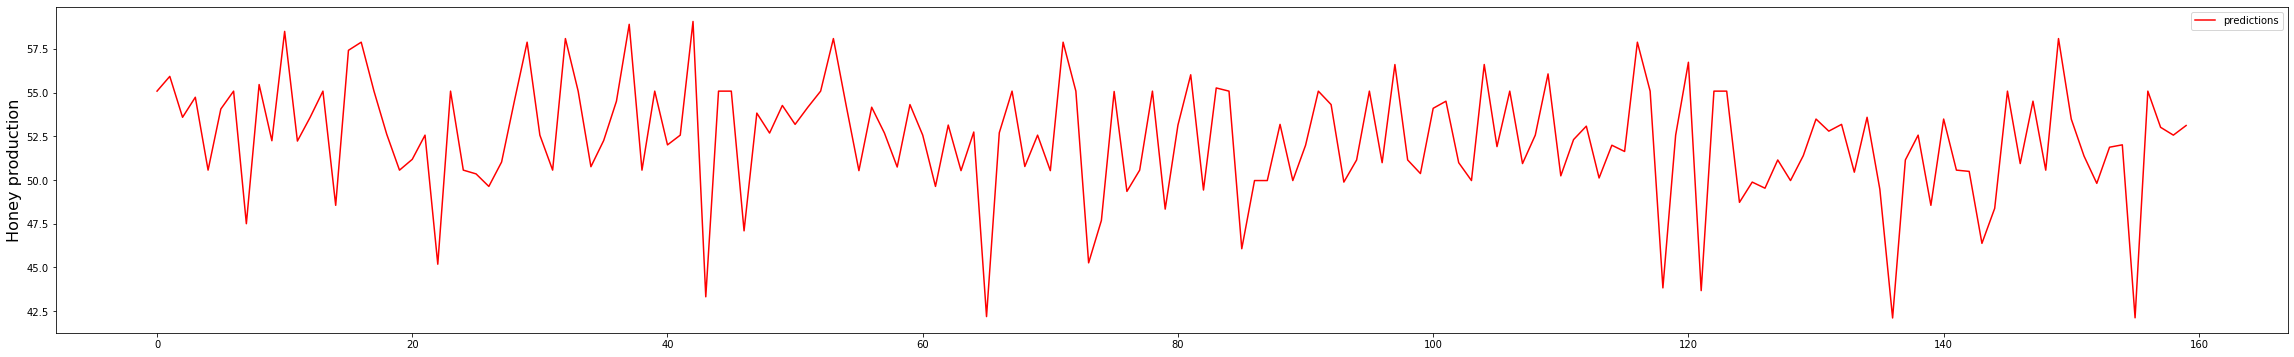

In [17]:
#visualizing the predictions
plt.figure(figsize=(40,6))
plt.plot(range(160), LGBM_preds[:160], color='r', label='predictions')
plt.ylabel('Honey production', size=16)
plt.legend()

In [36]:
#adding the predictions to the dataset
dtf_trs['Predictions'] = LGBM_preds

In [34]:
#saving it to an excel file to visualize it 
dtf_trs[['YEAR', 'STATE']].to_excel('climate_data_prediction.xlsx')